# Useful tools
This notebook contains some usefull functions for further analysis. 
One tool to determine the goodness of prediction and the other tools to determine the feature importance in the prediction.
This notebook was inspired by the one of the paper : Modern machine learning far outperforms GLMs at predicting spikes,   Benjamin et al, 2017
## Table of content



0. Load and transform data
0. Looking at the prediction score
0. Importance of features 


## Dependencies

Basics
 - matplotlib
 - numpy
 - pandas
 - scipy
 - warnings
 - itertools
 
Methods
 - xgboost
 

In [2]:
import warnings
import pandas as pd
import scipy.io
import numpy as np
import sys, os
import itertools



### 1. Load and transform data

The algorithm needs :
 - The data array X will be of dimensions (n, p), where n is the number of time bins and p is the number of covariates.
 - The response y will be of dimensions (n, 1).
 
 Transform your dataset.
 Below, please find an example of feature engineering

In [3]:
# WRITE DIRECTORY HERE
A_D = scipy.io.loadmat(os.path.expanduser('/Users/thomascortier/Documents/Stage_McGill/HDCellData/dico/data_test_PP20.mat'))

#### Data engineering

Different features : 
 - angular direction of the animal head
 - x position of the animal 
 - y position of the animal
 - speed of the animal

In [4]:
data            =   pd.DataFrame()
data['time']    =   np.arange(len(A_D['Ang']))      
data['ang']     =   A_D['Ang'].flatten()            
data['x']       =   A_D['X'].flatten()              
data['y']       =   A_D['Y'].flatten()              
data['vel']     =   A_D['speed'].flatten()


Firing data

In [5]:
for i in xrange(A_D['Pos'].shape[1]): data['Pos'+'.'+str(i)] = A_D['Pos'][:,i]
for i in xrange(A_D['ADn'].shape[1]): data['ADn'+'.'+str(i)] = A_D['ADn'][:,i]
nnPos= A_D['Pos'].shape[1]
nnADn= A_D['ADn'].shape[1]

### 2. Looking at the prediction score

- Cross validation function

The method fit_cv below returns a cross-validated pseudo-R2 score given data and an algorithm, here Xgboost.

In [24]:
from sklearn.model_selection import KFold


def poisson_pseudoR2(y, yhat, ynull):
    # This is our scoring function. Implements pseudo-R2
    yhat = yhat.reshape(y.shape)
    eps = np.spacing(1)
    L1 = np.sum(y*np.log(eps+yhat) - yhat)
    L1_v = y*np.log(eps+yhat) - yhat
    L0 = np.sum(y*np.log(eps+ynull) - ynull)
    LS = np.sum(y*np.log(eps+y) - y)
    R2 = 1-(LS-L1)/(LS-L0)
    return R2

def fit_cv(X, Y, algorithm,params= {'objective': "count:poisson", 
        'eval_metric': "logloss", 
        'seed': 2925, 
        'silent': 1,
        'learning_rate': 0.05,
        'min_child_weight': 2, 'n_estimators': 580,
        'subsample': 0.6, 'max_depth': 5, 'gamma': 0.4} ,num_round=100, n_cv=10, verbose=1):
    """Performs cross-validated fitting. Returns (Y_hat, pR2_cv); a vector of predictions Y_hat with the
    same dimensions as Y, and a list of pR2 scores on each fold pR2_cv.
    
    X  = input data
    Y = spiking data
    algorithm = a function of (Xr, Yr, Xt) {training data Xr and response Yr and testing features Xt}
                and returns the predicted response Yt
    n_cv = number of cross-validations folds
    
    """
    if np.ndim(X)==1:
        X = np.transpose(np.atleast_2d(X))

    cv_kf = KFold(n_splits=n_cv, shuffle=True, random_state=42)
    skf  = cv_kf.split(X)

    i=1
    Y_hat=np.zeros(len(Y))
    pR2_cv = list()
    for idx_r, idx_t in skf:
        if verbose > 1:
            print( '...runnning cv-fold', i, 'of', n_cv)
        i+=1
        Xr = X[idx_r, :]
        Yr = Y[idx_r]
        Xt = X[idx_t, :]
        Yt = Y[idx_t]

        Yt_hat = eval(algorithm)(Xr, Yr, Xt, params,num_round)
        Y_hat[idx_t] = Yt_hat

        pR2 = poisson_pseudoR2(Yt, Yt_hat, np.mean(Yr))
        pR2_cv.append(pR2)

        if verbose > 1:
            print( 'pR2: ', pR2)

    if verbose > 0:
        print("pR2_cv: %0.6f (+/- %0.6f)" % (np.mean(pR2_cv),
                                             np.std(pR2_cv)/np.sqrt(n_cv)))

    return Y_hat, pR2_cv



- Model function which trains the model with the given data and return a prediction. 

In [25]:
import xgboost as xgb
def xgb_run(Xr, Yr, Xt,params= {'objective': "count:poisson", 
        'eval_metric': "logloss", 
        'seed': 2925, 
        'silent': 1,
        'learning_rate': 0.05,
        'min_child_weight': 2, 'n_estimators': 580,
        'subsample': 0.6, 'max_depth': 5, 'gamma': 0.4}   ,num_round=100):
        

        dtrain = xgb.DMatrix(Xr, label=Yr)
        dtest = xgb.DMatrix(Xt)

        num_round = num_round
        bst = xgb.train(params, dtrain, num_round)

        Yt = bst.predict(dtest)
        return Yt

- Function which returns the predicted result with the training features and targets.

In [26]:
def pR2(X,nn,ta,n_trees=100,depth=5):
    params = {'objective': "count:poisson", #for poisson output
        'eval_metric': "logloss", #loglikelihood loss
        'seed': 2925, #for reproducibility
        'silent': 1,
        'learning_rate': 0.05,
        'min_child_weight': 2, 'n_estimators': 580,
        'subsample': 0.6, 'max_depth': n_trees, 'gamma': 0.4}   
    pR2_dict=dict()
    pR2=[]
    for i in range(nnPos):
        pR2.append(fit_cv(X,data[ta+'.'+str(i)].values,'xgb_run', params,n_trees, n_cv=8, verbose=1)[1])
        pR2_dict[ta+'.'+str(i)]=pR2[-1]
    pR2=np.array(pR2)
    return pR2_dict, np.mean(pR2) , np.std(pR2)/np.sqrt(np.size(pR2))
        
    
    

In [27]:
print(pR2(data[['ang','x','y','vel']].values,nnADn,'ADn')[1:])

pR2_cv: 0.511110 (+/- 0.001986)
pR2_cv: 0.685793 (+/- 0.001061)
pR2_cv: 0.857749 (+/- 0.000570)
pR2_cv: 0.882835 (+/- 0.000609)
pR2_cv: 0.037151 (+/- 0.007354)
pR2_cv: 0.710133 (+/- 0.001056)
pR2_cv: -0.750330 (+/- 0.010837)
pR2_cv: -0.429668 (+/- 0.012449)
pR2_cv: 0.796270 (+/- 0.001184)
pR2_cv: -0.397414 (+/- 0.006525)
pR2_cv: 0.755749 (+/- 0.001704)
pR2_cv: 0.253879 (+/- 0.002407)
pR2_cv: 0.253063 (+/- 0.002657)
pR2_cv: 0.671161 (+/- 0.001320)
pR2_cv: 0.463002 (+/- 0.001348)
(0.35336543166030432, 0.045865656444763266)


### 2. Looking at feature importance

#### a. Using p-R2 score per feature

- create the function to plot the feature importance

In [35]:
def bar_R2(R2_dict,f_compa,ta,nn):
    labels=[]
    mean=[]
    sem=[]
    a=0
    for l in f_compa.columns:
        K=np.zeros(nn)
        for i in range(nn):
            K[i]=np.mean(R2_dict[ta+'.'+str(i)][l])
        mean.append(np.mean(K))
        sem.append(np.std(K)/np.sqrt(np.size(K)))
        labels.append(l)
        a=a+1
    plt.bar(np.arange(np.size(mean)),mean, 0.8, align='center',
                    ecolor='k', alpha=.9, color='red', ec='w',yerr = sem ,
                    tick_label=labels)
    plt.plot(np.arange(np.size(mean)), mean, 'k.', markersize=15)
    plt.ylabel('Pseudo_R2')
    plt.show()

- Create the array with the features to compare

In [9]:
f_compa=data[[ 'ang', 'x', 'y', 'vel']]


- Function to create the dictionnary with the results for different neurons of one session. 

In [36]:
def comp_R2(f_compa,nn,ta,n_trees=50,depth=5):
    params = {'objective': "count:poisson", #for poisson output
        'eval_metric': "logloss", #loglikelihood loss
        'seed': 2925, #for reproducibility
        'silent': 1,
        'learning_rate': 0.05,
        'min_child_weight': 2, 'n_estimators': 580,
        'subsample': 0.6, 'max_depth': n_trees, 'gamma': 0.4}   
    R2_dict=dict()
    for i in range(nn):
        print(i)
        R2_dict[ta+'.'+str(i)]=dict()
        for keys in f_compa.columns:
            R2_dict[ta+'.'+str(i)][keys]=fit_cv(f_compa[keys].values,data[ta+'.'+str(i)].values,'xgb_run',params,n_trees, n_cv=8, verbose=1)[1]
    return R2_dict



In [ ]:
R2_dict=comp_R2(f_compa,nnPos,'Pos')
bar_R2(R2_dict,f_compa,ta,nn)

0
pR2_cv: 0.320640 (+/- 0.002164)
pR2_cv: 0.107286 (+/- 0.001905)
pR2_cv: 0.054016 (+/- 0.001395)
pR2_cv: 0.002525 (+/- 0.001126)
1
pR2_cv: 0.311384 (+/- 0.002595)
pR2_cv: 0.076674 (+/- 0.002462)
pR2_cv: 0.058048 (+/- 0.002629)
pR2_cv: -0.000094 (+/- 0.000838)
2
pR2_cv: 0.474184 (+/- 0.003484)
pR2_cv: 0.221788 (+/- 0.003022)
pR2_cv: 0.123434 (+/- 0.002846)
pR2_cv: 0.005792 (+/- 0.001005)
3
pR2_cv: 0.515440 (+/- 0.002409)
pR2_cv: 0.162379 (+/- 0.003947)
pR2_cv: 0.154952 (+/- 0.002447)
pR2_cv: 0.002363 (+/- 0.000529)
4
pR2_cv: 0.476049 (+/- 0.002651)
pR2_cv: 0.071112 (+/- 0.001641)
pR2_cv: 0.123703 (+/- 0.001790)
pR2_cv: 0.003311 (+/- 0.000636)
5
pR2_cv: 0.026449 (+/- 0.002820)
pR2_cv: -0.057542 (+/- 0.002879)
pR2_cv: -0.045759 (+/- 0.002685)
pR2_cv: -0.040627 (+/- 0.003119)
6


#### b. Looking at the split structure

- Function Spl to create a dictionay with the number of splits for each feature

In [15]:
import xgboost as xgb
import matplotlib.pyplot as plt

def Spl(X,y,n_trees=30,depth=2):
    params = {'objective': "count:poisson", #for poisson output
        'eval_metric': "logloss", #loglikelihood loss
        'seed': 2925, #for reproducibility
        'silent': 1,
        'learning_rate': 0.05,
        'min_child_weight': 0.1, 'n_estimators': 580,
        'subsample': 0.6, 'max_depth': depth, 'gamma': 0.4}  

    dtrain = xgb.DMatrix(X.values, label=y)
    num_round = n_trees
    bst = xgb.train(params, dtrain, num_round)

    Sp=extract_tree_threshold(bst)
    return Sp

def extract_tree_threshold(trees):
    n = len(trees.get_dump())
    thr = {}
    for t in range(n):
        gv = xgb.to_graphviz(trees, num_trees=t)
        body = gv.body
        for i in range(len(body)):
            for l in body[i].split('"'):
                if 'f' in l and '<' in l:
                    tmp = l.split("<")
                    if tmp[0] in thr:
                        thr[tmp[0]].append(float(tmp[1]))
                    else:
                        thr[tmp[0]] = [float(tmp[1])]
    for k in thr.keys():
        thr[k] = np.sort(np.array(thr[k]))
    return thr



- Function to plot the score distribution

In [ ]:
def bar_split(num_split,f_compa,ta,nn):
    labels=[]
    mean=[]
    sem=[]
    a=0
    for l in f_compa.columns:
        K=np.zeros(nn)
        for i in range(nn):
            if 'f'+str(a) in num_split[ta+'.'+str(i)].keys():
                K[i]=np.size(num_split[ta+'.'+str(i)]['f'+str(a)])
        mean.append(np.mean(K))
        sem.append(np.std(K)/np.sqrt(np.size(K)))
        labels.append(l)
        a=a+1
    plt.bar(np.arange(np.size(mean)),mean, 0.8, align='center',
                    ecolor='k', alpha=.9, color='red', ec='w',yerr = sem ,
                    tick_label=labels)
    plt.plot(np.arange(np.size(mean)), mean, 'k.', markersize=15)
    plt.ylabel('Number of splits')
    plt.show()

- Create the array with the features to compare

In [10]:
f_compa=data[[ 'ang', 'x', 'y', 'vel']]


- Create the dictionary  with the number of split distribution for each neuron

In [17]:
def Split_dict(f_compa,nn,ta,n_trees=30,depth=2):
    num_split=dict()
    for i in range(nn):
        print(i)
        num_split[ta+'.'+str(i)]=Spl(f_compa,data[ta+'.'+str(i)].values,n_trees,depth)
    return num_split

- Plot the split distribution

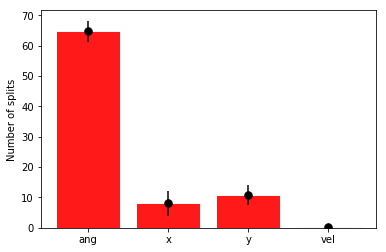

In [18]:
num_split=Split_dict(f_compa,nnPos,'Pos')
bar_split(num_split,f_compa,'Pos',nnPos)


#### c. Looking at the gain for feature importance

- Function to plot the gain repartition between features

In [33]:
def bar_gain(num_gain,f_compa,ta,nn):
    labels=[]
    mean=[]
    sem=[]
    for l in f_compa.columns:
        K=np.zeros(nn)
        for i in range(nn):
            if l in num_gain[ta+'.'+str(i)].keys():
                K[i]=np.sum(num_gain[ta+'.'+str(i)][l])
        mean.append(np.mean(K))
        sem.append(np.std(K)/np.sqrt(np.size(K)))
        labels.append(l)
    plt.bar(np.arange(np.size(mean)),mean, 0.8, align='center',
                    ecolor='k', alpha=.9, color='red', ec='w',yerr = sem ,
                    tick_label=labels)
    plt.plot(np.arange(np.size(mean)), mean, 'k.', markersize=15)
    plt.ylabel('Gain')
    plt.show()

- Function to create de dictionary with the gain distribution between features

In [20]:
def gain(X,Y,n_trees=30,depth=2):
    params = {'objective': "count:poisson", #for poisson output
    'eval_metric': "logloss", #loglikelihood loss
    'seed': 2925, #for reproducibility
    'silent': 1,
    'learning_rate': 0.05,
    'min_child_weight': 0, 'n_estimators': 580,
    'subsample': 0.6, 'max_depth': depth , 'gamma': 0.4}  

    dtrain = xgb.DMatrix(X,Y)     
    bst = xgb.train(params, dtrain, n_trees)
    return bst.get_score(importance_type = 'gain')

- The gain result for each neuron

In [29]:
def Gain_dict(f_compa,nn,ta,n_trees=30,depth=5):
    num_gain=dict()
    for i in range(nn):
        print(i)
        num_gain[ta+'.'+str(i)]=gain(f_compa,data[ta+'.'+str(i)].values)
    return num_gain

- Plot the result

0
{'y': 5.308505555555554, 'x': 5.55528, 'ang': 33.51814666666667}
1
{'y': 28.426393333333337, 'ang': 23.460203333333332}
2
{'x': 16.681583000000003, 'ang': 59.1375811111111}
3
{'y': 35.7793827586207, 'ang': 71.88658327868852}
4
{'ang': 57.65636574444445}
5
{'ang': 0.6218805333333332}
6
{'ang': 11.971543666666667}
7
{'x': 1.8251996666666663, 'ang': 59.63356666666666}
8
{'x': 9.188319, 'ang': 45.354975}
9
{'y': 3.711468666666667, 'x': 121.88019999999999, 'ang': 167.62489785714286}
10
{'y': 4.7724408333333335, 'ang': 109.4583847435898}
11
{'y': 4.534171612903227, 'vel': 22.077650000000002, 'ang': 29.7401}
12
{'ang': 165.10487238888894}
13
{'ang': 8.059584500000001}
14
{'y': 51.19805294117647, 'ang': 452.7114287671232}


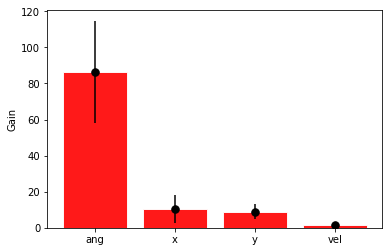

In [34]:
num_gain=Gain_dict(f_compa,nnPos,'Pos')
bar_gain(num_gain,f_compa,'Pos',nnPos)